### 1. Outlier Detection

---
The most straightforward approach to detecting potential fraud is identifying abnormal transactions. By "abnormal," we refer to transactions where certain features deviate significantly from the expected patterns.

Below is a list of some widely used outlier detection methods for testing:

INSEER THE FIG

1️⃣ Z-score (Statistic-based)  
2️⃣ Interquartile Range (IQR) (Statistic-based)  
3️⃣ Density-Based Spatial Clustering of Applications with Noise (DBSCAN) (Density-based)  
4️⃣ One-Class Support Vector Machine (SVM) (Machine Learning-based)  
5️⃣ Gaussian Mixiture Model (GMM) (Probability-based)  
6️⃣ K-Nearest Neighbors (KNN) (Distance-based)

Let us take on the **Z-score** and **IQR** methods only with **continuous** columns, excluding discrete features. This is because these statistical approaches are ineffective for detecting anomalies in categorical data, such as encoded values (`red = 0`, `blue = 1`), where "outlier-ness" cannot be meaningfully assessed.

#### Data Loading
---

In [ ]:
import os
from google.colab import userdata

# Copy Colab secrets as env vars
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
!pwd

/content


In [ ]:
# `import opendatasets as od` might not be flexible, so just make direct Kaggle API calls
from kaggle.api.kaggle_api_extended import KaggleApi
from tqdm import tqdm

# Initialize Kaggle API
api = KaggleApi()

# This authenticate() first looks for ~/.config/kaggle/kaggle.json (downloaded from Kaggle | Settings | API | Create New Token that includes username and API key)
# If the JSON file is not present the command looks into the env vars
api.authenticate()

# Dataset identifier
owner = "sgpjesus"
dataset = "bank-account-fraud-dataset-neurips-2022"
owner_and_dataset_name = owner + "/" + dataset
download_zip_file_name = dataset + ".zip"
extracted_csv_file_name = "Base.csv"

# Get dataset metadata to retrieve file size
dataset_metadata = api.dataset_list_files(owner_and_dataset_name).files

In [ ]:
import pprint
pprint.pprint(dataset_metadata)

[{"ref": "", "datasetRef": "", "ownerRef": "", "name": "Base.csv", "creationDate": "2023-11-29T11:32:19.356Z", "description": "", "fileType": "", "url": "", "totalBytes": 213427735, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant I.csv", "creationDate": "2023-11-29T11:32:19.724Z", "description": "", "fileType": "", "url": "", "totalBytes": 213400445, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant II.csv", "creationDate": "2023-11-29T11:32:19.511Z", "description": "", "fileType": "", "url": "", "totalBytes": 213537521, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant III.csv", "creationDate": "2023-11-29T11:32:21.193Z", "description": "", "fileType": "", "url": "", "totalBytes": 252204320, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant IV.csv", "creationDate": "2023-11-29T11:32:20.744Z", "description": "", "fileType": "", "url": "", "totalBytes": 213538370, "c

In [ ]:
api.dataset_metadata(owner_and_dataset_name, path=".")
!cat ./dataset-metadata.json

"{\"datasetId\": 2673949, \"datasetSlug\": \"bank-account-fraud-dataset-neurips-2022\", \"ownerUser\": \"sgpjesus\", \"usabilityRating\": 1.0, \"totalViews\": 95853, \"totalVotes\": 172, \"totalDownloads\": 14676, \"title\": \"Bank Account Fraud Dataset Suite (NeurIPS 2022)\", \"subtitle\": \"Biased, Imbalanced, Dynamic Tabular Datasets for ML Evaluation.\", \"description\": \"The Bank Account Fraud (BAF) suite of datasets has been published at **NeurIPS 2022** and it comprises a total of 6 different synthetic bank account fraud tabular datasets. BAF is a realistic, complete, and robust test bed to evaluate novel and existing methods in ML and fair ML, and the first of its kind!\\n\\n\\n**This suite of datasets is:**\\n- Realistic, based on a present-day real-world dataset for fraud detection;\\n- Biased, each dataset has distinct controlled types of bias;\\n- Imbalanced, this setting presents a extremely low prevalence of positive class;\\n- Dynamic, with temporal data and observed di

In [ ]:
total_csv_file_size = sum([csv_file.total_bytes for csv_file in dataset_metadata])

# Download dataset with progress tracking
with tqdm(total=total_csv_file_size, unit='B', unit_scale=True, unit_divisor=1024, desc="Downloading Dataset") as bar:
    api.dataset_download_files(owner_and_dataset_name, path=".", unzip=False)
    downloaded_size = os.path.getsize(download_zip_file_name)
    bar.update(downloaded_size)

print("Download complete!")


Dataset URL: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022


Download complete!


In [ ]:
#import zipfile module
from zipfile import ZipFile

with ZipFile(dataset + ".zip", "r") as f:
  #extract only one file, Base.csv, in current directory
  f.extract(extracted_csv_file_name)

#### Preprocessing
---


In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)
df = pd.read_csv(extracted_csv_file_name)
print(df.head())

   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  \
0              102.453711           AA          1059  13096.0350

In [ ]:
label_target ="fraud_bool"
label_zscore = "Z-score"
label_iqr = "IQR"
label_outlier_count = "Outlier Counts"
label_feature = "Features"
label_count = "Counts"
label_fraud_count = "Fraud Cases"
label_method = "Methods"
label_value = "Values"

format_decimals = ".2f"

def format_thousands(var) -> str:
  return f"{var:,.0f}" if type(var) == int or type(var) == float else "{x:,.0f}"

In [ ]:
total_fraud_count = (df[label_target] == 1).sum()

# def add_thousand_separator_to_int(num: int) -> str:
#   return "{:,}".format(num)

print("This dataset includes " +
      format_thousands(df.shape[0]) +
      " rows, of which " +
      format_thousands(total_fraud_count) +
      " are marked as fraud.")

This dataset includes 1,000,000 rows, of which {x:,.0f} are marked as fraud.


In [ ]:
# The number of columns
print(df.shape[1])

32


In [ ]:
print(df.describe())

           fraud_bool          income  name_email_similarity  \
count  1000000.000000  1000000.000000         1000000.000000   
mean         0.011029        0.562696               0.493694   
std          0.104438        0.290343               0.289125   
min          0.000000        0.100000               0.000001   
25%          0.000000        0.300000               0.225216   
50%          0.000000        0.600000               0.492153   
75%          0.000000        0.800000               0.755567   
max          1.000000        0.900000               0.999999   

       prev_address_months_count  current_address_months_count  \
count             1000000.000000                1000000.000000   
mean                   16.718568                     86.587867   
std                    44.046230                     88.406599   
min                    -1.000000                     -1.000000   
25%                    -1.000000                     19.000000   
50%                    -1.0

In [ ]:
# This stats table omits categorical values!
print(df.describe().shape[1])

27


In [ ]:
# Drop the "device_fraud_count" column as all zeros
df = df.drop("device_fraud_count", axis=1)

In [ ]:
print("The numbere of missing data cell count = " + str(df.isnull().any(axis=1).sum()))

The numbere of missing data cell count = 0


In [ ]:
print(df.dtypes)

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

In [ ]:
X = df.copy()

# Seprate the dependent/target variable
y = X.pop(label_target)

# Loop through every column
for column in X.columns:
    # Check if the column is of type 'int64' and contains only 0 and 1
    if X[column].dtype == "int64" and X[column].isin([0, 1]).all():
        # Convert to boolean type
        X[column] = X[column].astype(bool)

print(X.dtypes)

income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                          bool
housing_status                       object
phone_home_valid                       bool
phone_mobile_valid                     bool
bank_months_count                     int64
has_other_cards                        bool
proposed_credit_limit           

In [ ]:
# There is no point of applying correlation or StandardScaler on "bool" and "object (string)"" as they would be meaningless
# Cannot remove both at one go, so one by one
X_no_bool = X.select_dtypes(exclude=bool)
X_no_string_or_bool = X_no_bool.select_dtypes(exclude=["object"])

#### Linear Correlation
---



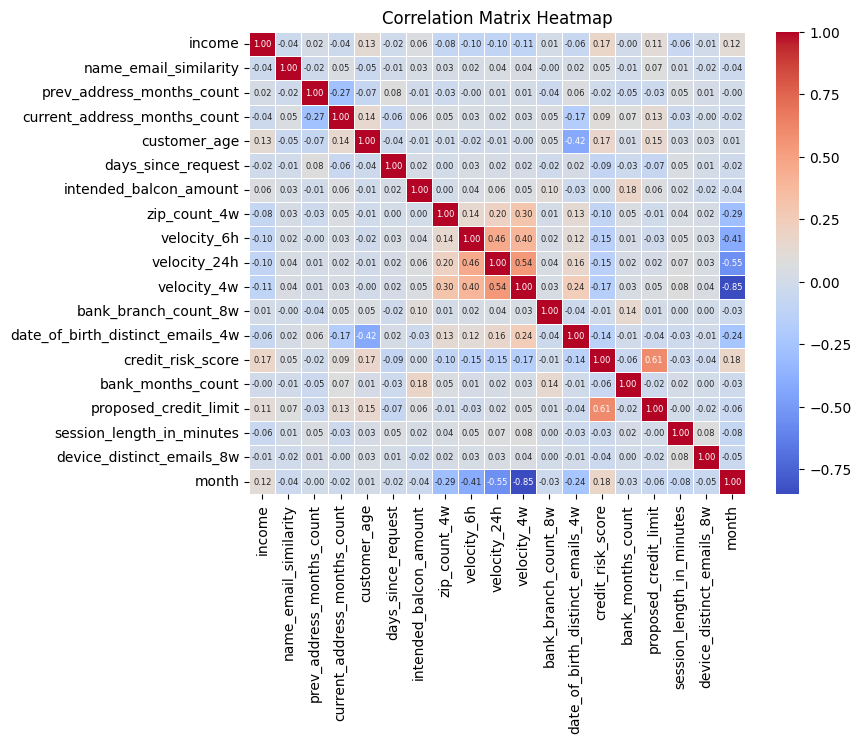

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))

# The defaulgt annot_kws's size is 10
sns.heatmap(X_no_string_or_bool.corr(method="pearson"), annot=True, annot_kws={"size": 6}, cmap="coolwarm", fmt=format_decimals, linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

Virtually no one feature strongly correlates with another - **linearly**.

#### Normally distributed or skewed?
---
Comparing StandardScaler and MinMaxScaler helps find out the answer.

INSERT THE FIG

In [ ]:
def draw_boxplot(data: pd.DataFrame,
                 title: str,
                 ylabel: str,
                 xlabel: str) -> None:
  plt.figure(figsize=(6, 4))
  sns.boxplot(data=data, orient="h") # Flips x and y axes by "orient="h"
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid(True)
  plt.show()

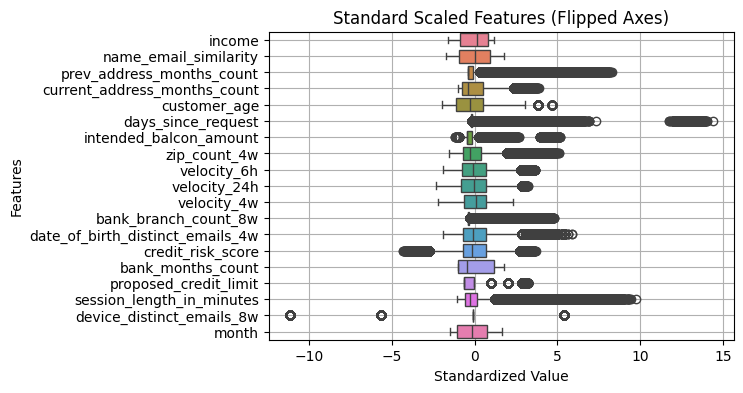

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standard_scaled = pd.DataFrame(scaler.fit_transform(X_no_string_or_bool), columns=X_no_string_or_bool.columns)

draw_boxplot(X_standard_scaled,
             "Standard Scaled Features (Flipped Axes)",
             label_feature,
             "Standardized Value")

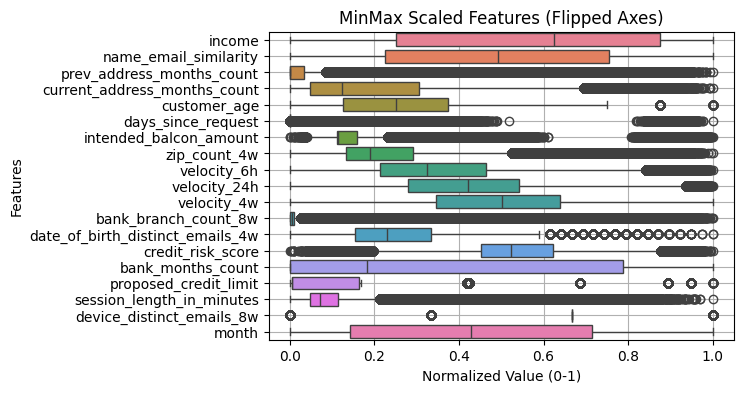

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_no_string_or_bool), columns=X_no_string_or_bool.columns)

draw_boxplot(X_minmax_scaled,
             "MinMax Scaled Features (Flipped Axes)",
             label_feature,
             "Normalized Value (0-1)")

# # Plot with flipped axes
# plt.figure(figsize=(6, 4))
# sns.boxplot(data=X_minmax_scaled, orient="h") # Flips x and y axes by "orient="h""
# plt.title("MinMax Scaled Features (Flipped Axes)")
# plt.xlabel("Normalized Value (0-1)")
# plt.ylabel("Features")
# plt.grid(True)
# plt.show()

Outliers play a significant role in how **StandardScaler** and **MinMaxScaler** transform data, which can lead to differences in their resulting shapes.

Here's why:

1. StandardScaler (Z-score normalization)
   - Centers the data (zero mean) and scales it to unit variance.  
   - Outliers stretch the scale, influencing the mean and standard deviation.  
   - This can cause a more spread-out distribution in the transformed data.

2. MinMaxScaler (Range normalization)
   - Scales values to a fixed range, typically `[0,1]`.  
   - Outliers compress the distribution, pushing regular values closer together.  
   - This leads to more skewed and squeezed transformations if extreme values are present.

Why do their shapes differ?  
- If there are many outliers, StandardScaler will maintain a broader spread, whereas MinMaxScaler will compress most values into a tight range while stretching extreme ones.  
- This results in different distributions and potentially distinct shapes when visualizing the scaled data.



[The challenges of AML transaction monitoring](https://linkurious.com/transaction-monitoring-in-aml/#the-challenges-of-aml-transaction-monitoring) succinctly summarize the ever-evolving nature of this practice.  
> "Many AML transaction monitoring systems depend on static rules to flag potentially suspicious behavior. These systems do a good job of turning up known anomalies - but they don’t take context into account and often miss part of the picture.

> "These traditional rules-based monitoring systems also often generate **a high number of false positives** (this scenario), overwhelming investigators with alerts and making it challenging to distinguish genuine threats from noise."

> "At the same time, money launderers are becoming increasingly sophisticated in disguising their illicit activities. They adapt to the rules flagged by transaction monitoring to fly under the radar, leading to false negatives.This underscores the necessity for institutions to adopt more advanced and adaptive solutions."

This is where, I strongly believe, Artificial Intelligence (AI) becomes a game-changer.

1. Statistic-based Method (Z-score and IQR)
---

In [ ]:
def get_zscore_per_col(series: pd.Series) -> pd.Series:
    return np.abs(zscore(series)) > 3

def get_iqr_per_col(series: pd.Series) -> pd.Series:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))

In [ ]:
import numpy as np
from scipy.stats import zscore

outlier_method_and_result_list = [[label_zscore], [label_iqr]]

# Initialize outlier counter
outlier_counter = pd.Series(0, index=df.index, name = label_outlier_count)

for method_idx in range(len(outlier_method_and_result_list)):
  # No point in using "X_standard_scaled" as the base dataframe because it is normalised with mean of 0 and st. dev. of 1, effectively having removed outlier-ness.
  for col in X_no_string_or_bool.columns:
    match str(outlier_method_and_result_list[method_idx][0]):
      case "Z-score":
        outlier_counts = get_zscore_per_col(X_no_string_or_bool[col])
      case "IQR":
        outlier_counts = get_iqr_per_col(X_no_string_or_bool[col])
      case _: # the default wild card
        print("Error")

    # Count outliers per row
    outlier_counter += outlier_counts.astype(int)

  # Add two Series together into a new DataFrame
  X_fraud_bool_and_outlier_counter = pd.concat([y, outlier_counter], axis=1)

  # Group by "label_outlier_count" and sum the "label_target"
  # Convert back to a regular DataFrame using the reset_index() method
  X_fraud_bool_and_outlier_counter_grouped = X_fraud_bool_and_outlier_counter.groupby(label_outlier_count)[label_target].sum().reset_index()

  # Add it to the list as a second element
  outlier_method_and_result_list[method_idx].append(X_fraud_bool_and_outlier_counter_grouped)

In [ ]:
def draw_outlier_barplot(data: pd.DataFrame,
                 title_name: str) -> None:
  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=label_outlier_count, y=label_target, data=data)

  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(format_thousands("x")))
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(format_thousands("x")))
  # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

  for idx in range(len(data)):
      # ax.text(idx, data[label_target][idx] + 50, format_thousands(data[label_target][idx]), ha="center", fontsize=10)
      ax.text(idx, data[label_target][idx] + 50, f"{data[label_target][idx]:,.0f}", ha="center", fontsize=10)

  # Adding labels and title
  plt.xlabel(label_outlier_count)
  plt.ylabel(label_fraud_count)
  plt.title(title_name)
  plt.show()

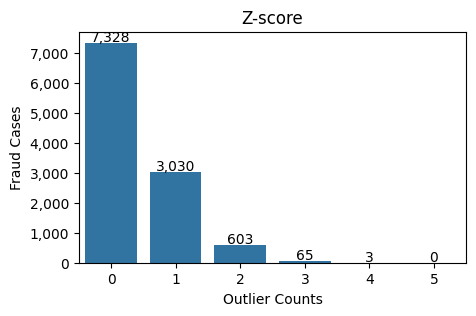

In [ ]:
draw_outlier_barplot(outlier_method_and_result_list[0][1], label_zscore)

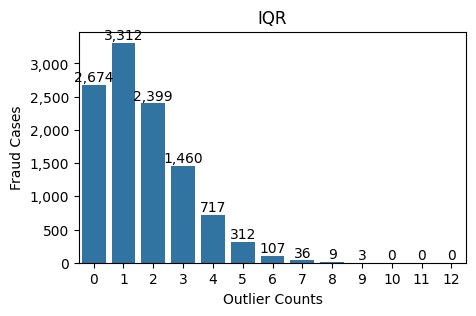

In [ ]:
draw_outlier_barplot(outlier_method_and_result_list[1][1], label_iqr)

The two histograms above indicate that detecting more outliers in features does not necessarily improve fraud detection. In fact, features with fewer outlier counts tend to correspond to a higher number of fraud cases.

Let's take a closer look at the features with the highest outlier counts that are also marked as "fraud."

In [ ]:
# Initialize an empty dataframe
df_feature_outlier_result = pd.DataFrame(columns=[label_feature, label_count], dtype=int)

# Initialize outlier counter
outlier_flag_series = pd.Series(0, index=df.index, name = label_outlier_count)

for method_idx in range(len(outlier_method_and_result_list)):
  for col in X_no_string_or_bool.columns:
    match str(outlier_method_and_result_list[method_idx][0]):
      case 'Z-score':
        outlier_flag_series = get_zscore_per_col(X_no_string_or_bool[col])
      case 'IQR':
        outlier_flag_series = get_iqr_per_col(X_no_string_or_bool[col])
      case _: # the default wild card
        print("Error")

    # Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
    # No need to specify column name for a Series like:
    #   count = (y[label_target] * outlier_flag_series[outlier_count_col_title] == 1).sum()
    count = (y * outlier_flag_series == 1).sum()

    # Add the result to the first dataframe using loc
    df_feature_outlier_result.loc[len(df_feature_outlier_result)] = [col, count]

  # Add it to the list as a second element
  outlier_method_and_result_list[method_idx].append(df_feature_outlier_result.copy(deep=True))

  # This removes all rows but retains the column names and data types.
  df_feature_outlier_result.drop(df_feature_outlier_result.index, inplace=True)

In [ ]:
def draw_outlier_by_feature_barplot(data: pd.DataFrame,
                                    method_name: str) -> None:
# data:
#     Feature Count
# 18 	None 	None
# 19 	income 	0
# 21 	prev_address_months_count 	575

# In a row, When 'Feature' and 'Count' shows
# 1. Both 'None'
#   The particular feature is never counted as an outlier by the method chosen
# 2. Feature name printed and 0
#   The particular feature is counted as an outlier BUT no fraud case is found when its value is an ourlier
# 3. Feature name printed and non-zero
#   The particular feature is counted as an outlier AND one or more fraud case is found

  # Drop rows where both 'Feature' and 'Count' are None
  data_none_removed = data.dropna(subset=[label_feature, label_count], how='all')

  # Sort in a descending order
  data_none_removed = data_none_removed.sort_values(by=label_count, ascending=False)

  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=label_count, y=label_feature, data=data_none_removed, orient="h")

  # Do not need this as the Y-axis shows categorical values, only the X-axis
  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

  # for idx in range(len(data)):
  #   ax.text(idx, data[label_target][idx] + 50, f"{data[label_target][idx]:,.0f}", ha="center", fontsize=10)
  ax.bar_label(ax.containers[0], fmt="{:,.0f}")
  # ax.bar_label(ax, fmt="{:,.0f}")

  # Adding labels and title
  plt.xlabel(label_fraud_count)
  plt.ylabel(label_feature)
  plt.title(method_name)
  plt.show()

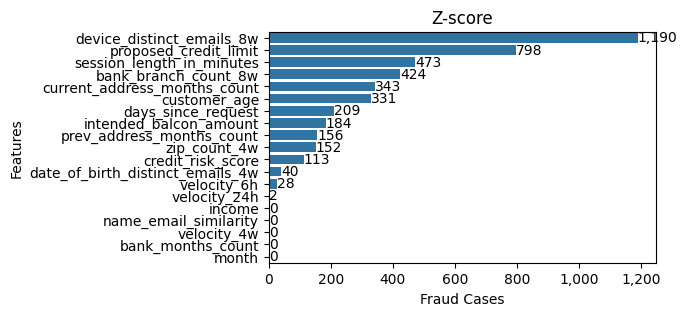

In [ ]:
draw_outlier_by_feature_barplot(outlier_method_and_result_list[0][2], label_zscore)

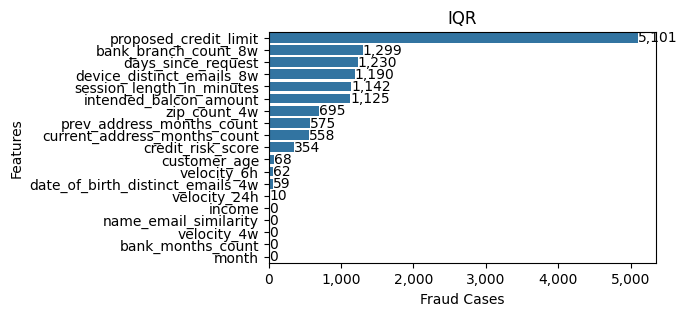

In [ ]:
draw_outlier_by_feature_barplot(outlier_method_and_result_list[1][2], label_iqr)

I have not overlooked binary, Boolean, and categorical features. I briefly examine them to determine if any notable patterns emerge in relation to detected fraud.

In [ ]:


# def get_df_and_col_names_by_single_dtype(df: pd.DataFrame, dtype_name: str) -> tuple:
#   X_selected_dtypes = X.select_dtypes(dtype_name)

# # CREATE AN EMPTY LIST TO STORE ALL THE LIST OF ACTUAL VALUES FOR EACH BOOLEAN FEILD - WITH ITS NAME

#   # for colname in X_selected_dtypes:
#   #     codes, uniques = X[colname].factorize(sort=True)
#   #     print(codes)
#   #     print(uniques)

#   return X_selected_dtypes, uniques

def get_fraud_count_by_single_dtype(df: pd.DataFrame, dtype_name: str) -> list:
  df_selected_dtype = df.select_dtypes(dtype_name)
  list_of_list_col_names = [[col_name] for col_name in df_selected_dtype.columns]

  for list_col in list_of_list_col_names:
    # put 'fraud_bool' (y) and a boolean/encoded valued column together into a new DataFrame
    df_concatenated = pd.concat([y,  df_selected_dtype[list_col[0]]], axis=1)

    # Change column names for FacetGrid later
    df_concatenated.rename(columns={list_col[0]: label_value}, inplace=True)
    df_concatenated.rename(columns={label_target: label_fraud_count}, inplace=True)

    # Group by "list_col[0]" and sum the "label_target"
    # Convert back to a regular DataFrame using the reset_index() method
    df_concatenated_grouped = df_concatenated.groupby(label_value)[label_fraud_count].sum().reset_index()

    # Add it to the list as a second element
    list_col.append(df_concatenated_grouped)

  return list_of_list_col_names


def get_fraud_count_in_facetgrid(list_source: list) -> None:
  # Combine data into a single DataFrame
  # Need to use "##{varName}" to dynamically assign a variable name as a column name of the combined DataFrame
  df_combined = pd.concat(
      [df_bool.assign(**{label_feature:feature_name}) for feature_name, df_bool in list_source],
      ignore_index=True
  )

  g = sns.FacetGrid(df_combined, col=label_feature)
  ax = sns.barplot
  g.map_dataframe(ax, x=label_value, y=label_fraud_count)

  g.set(xlabel=None)

  # Apply the formatter to each axis in the FacetGrid
  for ax in g.axes.flat:
    # ax.yaxis.set_major_formatter(FuncFormatter("{x:,.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.bar_label(ax.containers[0], fmt="{:,.0f}")
  plt.show()

In [ ]:
list_bool_fraud_counts = get_fraud_count_by_single_dtype(X, 'bool')

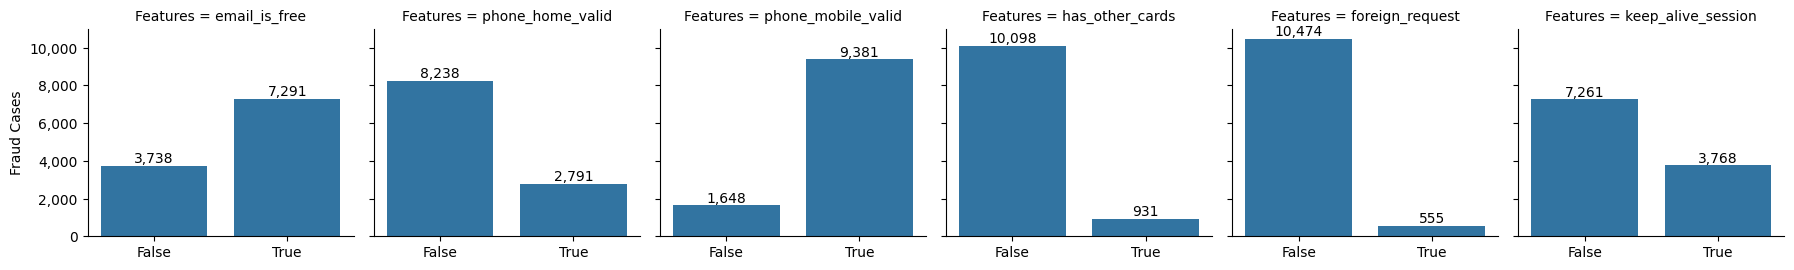

In [ ]:
get_fraud_count_in_facetgrid(list_bool_fraud_counts)

The features **phone_mobile_valid**, **has_other_cards**, and **foreign_request** show a noticeable contrast between their True and False values. I will further analyze them using a Confusion Matrix.


In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FuncFormatter


def get_confusion_matrix(df: pd.DataFrame, col_name: str) -> None:
  # Define a function to format the ticks
  def format_thousands(x, pos):
      return f'{int(x):,}'

  cm = confusion_matrix(y, df[col_name])

  # quadrants = {
  # "True Negative (TN)": cm[0][0],
  # "False Positive (FP)": cm[0][1],
  # "False Negative (FN)": cm[1][0],
  # "True Positive (TP)": cm[1][1]
  # }

  group_counts = ["{0:,.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{g1}\n({g2})" for g1, g2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(4, 2))
  heatmap = sns.heatmap(cm, annot=labels, fmt="", cbar=False, cmap="coolwarm", xticklabels=["True", "False"], yticklabels=["True", "False"])

  # Apply the formatter to the colorbar
  colorbar = heatmap.collections[0].colorbar

  # Automatically set the ticks based on the data range
  # Number of ticks = 8 (default on Heatmap)
  # colorbar.set_ticks(np.linspace(max(quadrants.values()), max(quadrants.values()), 8))
  # colorbar.set_ticks([1000, 10000, 50000, 100000])
  # colorbar.set_ticklabels([format_thousands(x, None) for x in colorbar.get_ticks()])
  # colorbar.ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

  plt.xlabel(col_name)
  plt.ylabel("Fraud")
  plt.title('Confusion Matrix')
  plt.show()

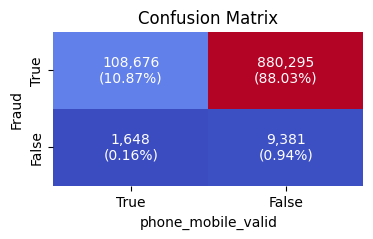

In [ ]:
get_confusion_matrix(X, "phone_mobile_valid")

list_col_names_cm = [
                      "phone_mobile_valid",
                      "has_other_cards",
                      "foreign_request"
                    ]


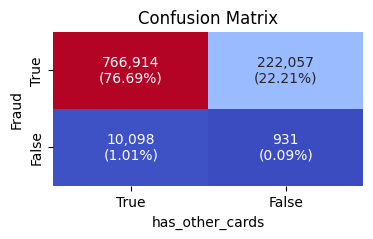

In [ ]:
get_confusion_matrix(X, "has_other_cards")

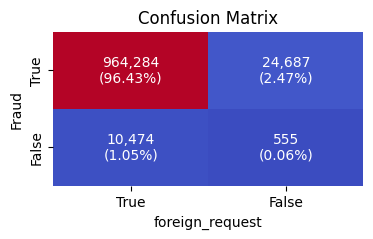

In [ ]:
get_confusion_matrix(X, "foreign_request")

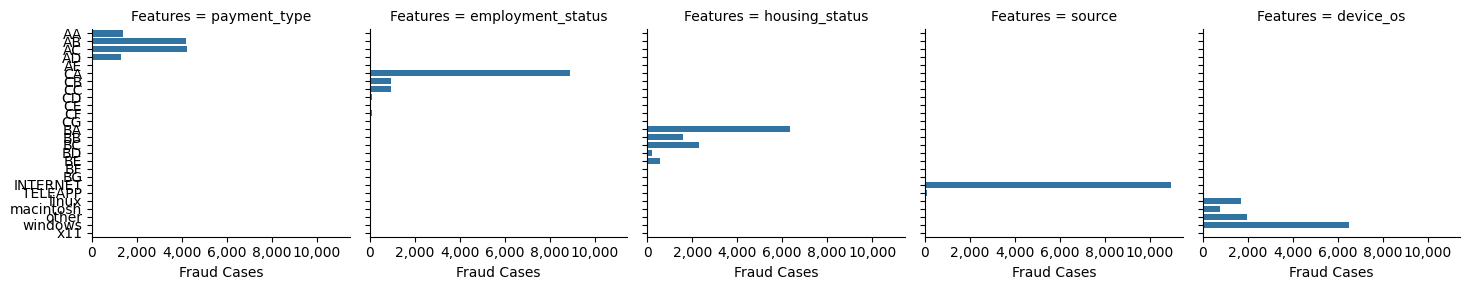

In [ ]:
list_object_fraud_counts = get_fraud_count_by_single_dtype(X, 'object')
get_fraud_count_in_facetgrid(list_object_fraud_counts)

I will dig into more details with Confusion Matrix.

In [ ]:
# X_onlY_categoricals, list_sorted_categoricals = get_df_and_col_names_by_single_dtype(X, 'object')
list_categorical_fraud_counts = get_fraud_count_by_single_dtype(X, 'object')

[0 3 1 ... 0 1 0]
Index(['AA', 'AB', 'AC', 'AD', 'AE'], dtype='object')
[1 0 0 ... 0 0 0]
Index(['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG'], dtype='object')
[2 2 2 ... 4 3 1]
Index(['BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG'], dtype='object')
[0 0 0 ... 0 0 0]
Index(['INTERNET', 'TELEAPP'], dtype='object')
[0 2 3 ... 2 0 2]
Index(['linux', 'macintosh', 'other', 'windows', 'x11'], dtype='object')


In [ ]:
list_bool_fraud_counts

[['email_is_free',
     email_is_free  fraud_bool
  0          False        3738
  1           True        7291],
 ['phone_home_valid',
     phone_home_valid  fraud_bool
  0             False        8238
  1              True        2791],
 ['phone_mobile_valid',
     phone_mobile_valid  fraud_bool
  0               False        1648
  1                True        9381],
 ['has_other_cards',
     has_other_cards  fraud_bool
  0            False       10098
  1             True         931],
 ['foreign_request',
     foreign_request  fraud_bool
  0            False       10474
  1             True         555],
 ['keep_alive_session',
     keep_alive_session  fraud_bool
  0               False        7261
  1                True        3768]]

array([0, 3, 1, ..., 0, 1, 0])
Index(['AA', 'AB', 'AC', 'AD', 'AE'], dtype='object')
array([1, 0, 0, ..., 0, 0, 0])
Index(['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG'], dtype='object')
array([2, 2, 2, ..., 4, 3, 1])
Index(['BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG'], dtype='object')
array([0, 0, 0, ..., 0, 0, 0])
Index(['INTERNET', 'TELEAPP'], dtype='object')
array([0, 2, 3, ..., 2, 0, 2])
Index(['linux', 'macintosh', 'other', 'windows', 'x11'], dtype='object')


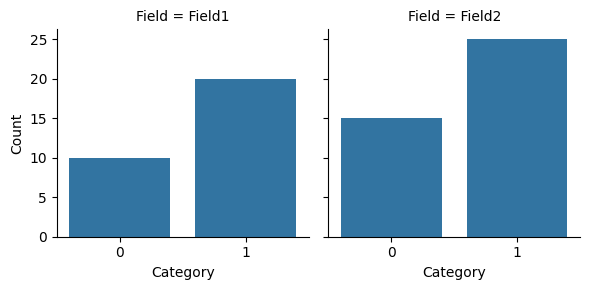

In [ ]:

# Sample data
data = [
    ["Field1", pd.DataFrame({"Category": [0, 1], "Count": [10, 20]})],
    ["Field2", pd.DataFrame({"Category": [0, 1], "Count": [15, 25]})]
]

# Combine data into a single DataFrame
combined_data = pd.concat(
    [df.assign(Field=name) for name, df in list_bool_fraud_counts],
    ignore_index=True
)

# Create the FacetGrid
g = sns.FacetGrid(combined_data, col="Field")
g.map_dataframe(sns.barplot, x="Category", y="Count")

# Display the plot
plt.show()


When Z-score is more useful than IQR?

1. When Data is Normally Distributed (Bell-Shaped)
- Z-score assumes data follows a Gaussian (normal) distribution.
- If your dataset is symmetric and bell-shaped, Z-score is ideal because it standardizes values based on mean and standard deviation.

2. When Detecting Outliers in Continuous Data
- Works best for datasets with continuous numerical values, such as age, income, or temperatures.
- Since Z-score transforms values into a standardized scale, it effectively spots extreme deviations.

3. When Working with Large Datasets
- In massive datasets, IQR can struggle to detect subtle variations.
- Z-score scales well and provides a more precise measure of how far a data point deviates from the mean.

4. When You Need a Standardized Measure for Comparison
- Z-score allows comparisons across different datasets.
- For example, if two different datasets have different scales (one in dollars, another in kilograms), Z-score makes values comparable by converting them to standard deviations.

5. When You Expect Global Outliers (Extreme Deviations)
- Z-score effectively captures global outliers, meaning data points that are extremely different from the overall dataset.
- IQR is better at detecting local outliers, meaning values that might be extreme in a specific subset but not necessarily across the entire dataset.

Based on the observed outliers, the **proposed_credit_limit** identified by the IQR method carries more weight in predicting fraud than **device_distinct_emails_8w** identified by the Z-score method.

The remaining methods require computing resources and time.

In [ ]:
# Each of the following methods take a long compute time, so let us measure it
import time

def measure_duration(start_time: float) -> None:
  end_time = time.time()
  duration = end_time - start_time
  hours = int(duration // 3600)
  minutes = int((duration % 3600) // 60)
  seconds = duration % 60
  formatted_duration = f"Duration: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds"
  print(formatted_duration)

In [ ]:
# Initialize an empty dataframe
# This stores the fraud hit counts by each method
df_method_ourlier_result = pd.DataFrame(columns=[label_method, label_count], dtype=int)

2. Density-based Method (Density-Based Spatial Clustering of Applications with Noise (DBSCAN))
---

In [ ]:
# 1h 13m to complete
from sklearn.cluster import DBSCAN

start_time = time.time()

# Density-Based Spatial Clustering of Applications with Noise
dbscan = DBSCAN(eps=1.5, min_samples=2)
labels = dbscan.fit_predict(X_standard_scaled)

# Mark outliers (DBSCAN labels outliers as -1)
dbscan_outliers = (labels == -1)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
dbscan_outlier_count = (y * dbscan_outliers == 1).sum()
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ['DBSCAN', dbscan_outlier_count]

measure_duration(start_time)

3. Machine Learnig-based Method (One-Class Support Vector Machine (SVM))
---

In [ ]:
from sklearn.svm import OneClassSVM

start_time = time.time()

oc_svm = OneClassSVM(kernel='rbf', nu=0.05)  # Adjust 'nu' for sensitivity
oc_svm.fit(X_standard_scaled)

# Predict outliers (-1 = outlier, 1 = normal)
predictions = oc_svm.predict(X_standard_scaled)

# Mark outliers in DataFrame
oc_svm_outliers = (predictions == -1)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
oc_outlier_count = (y * oc_svm_outliers == 1).sum()
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ['OneClassSVM', oc_outlier_count]

measure_duration(start_time)

4. Probability-based Method (Gaussian Mixiture Model (GMM))
---

In [ ]:
from sklearn.mixture import GaussianMixture

start_time = time.time()

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_standard_scaled)

# Compute probability scores
probs = gmm.predict_proba(X_standard_scaled).max(axis=1)

# Set threshold (low probability = outlier)
threshold = np.percentile(probs, 5)  # 5th percentile
gmm_outliers = (probs < threshold)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
gmm_outlier_count = (y * gmm_outliers == 1).sum()
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ['GMM', gmm_outlier_count]

measure_duration(start_time)

5. Distance-based Method (K-Nearest Neighbors (KNN))
---

In [ ]:
from sklearn.neighbors import NearestNeighbors

start_time = time.time()

nbrs = NearestNeighbors(n_neighbors=3)
nbrs.fit(X_standard_scaled)
distances, indices = nbrs.kneighbors(X_standard_scaled)

# Compute the mean distance to k-nearest neighbors
mean_distances = distances.mean(axis=1)

# Set threshold as the 95th percentile
threshold = np.percentile(mean_distances, 95)

knn_outliers = (mean_distances > threshold)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
knn_outlier_count = (y * knn_outliers == 1).sum()
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ['KNN', knn_outlier_count]

measure_duration(start_time)

In [ ]:
def draw_outlier_by_method_barplot(data: pd.DataFrame) -> None:
  # Sort in a descending order
  data_none_removed = data_none_removed.sort_values(by=label_count, ascending=False)

  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=label_count, y=label_feature, data=data_none_removed, orient="h")

  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
  ax.bar_label(ax.containers[0])

  # Adding labels and title
  plt.xlabel(label_feature)
  plt.ylabel(label_fraud_count)
  plt.title(label_outlier_count + " (out of " + total_fraud_count )
  plt.show()

In [ ]:
draw_outlier_by_method_barplot(df_method_ourlier_result)

#### Feature engineering

>A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

>The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

>It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.

>The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

Mutual information feature selection can be quite useful in a supervised binary classification setting. It helps identify the most relevant features by measuring the amount of information a given feature shares with the target variable. Here’s why it’s valuable:

- **Captures Non-Linear Dependencies**: Unlike correlation-based methods, mutual information can detect both linear and non-linear relationships between features and the target.
- **Improves Model Efficiency**: By selecting only the most informative features, it reduces dimensionality, speeds up training, and enhances generalization.
- **Handles Mixed Data Types**: Mutual information works for categorical and continuous data alike, making it versatile across different datasets.

However, it does have limitations:
- **Computational Cost**: Estimating mutual information can be computationally expensive, especially with large datasets.
- **Feature Redundancy**: If multiple features provide similar information, mutual information might not effectively filter them out.

In practice, mutual information is often combined with other techniques—like recursive feature elimination or regularization-based selection—to get the best results.

Absolutely! Combining **Mutual Information (MI)** with **Recursive Feature Elimination (RFE)** can be a powerful way to refine your feature selection for a binary classification model. Here’s a step-by-step approach using Python:

---

### **Step 1: Import Necessary Libraries**
You'll need `mutual_info_classif`, `RFE`, and a classifier (like `RandomForestClassifier` or `LogisticRegression`).

```python
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
```

---

### **Step 2: Load & Prepare Data**
Let's assume we have a dataset `df` with features and a target column named `'target'`.

```python
X = df.drop(columns=['target'])  # Features
y = df['target']  # Target variable
```

---

### **Step 3: Compute Mutual Information Scores**
Find the most informative features using **Mutual Information**.

```python
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Set a threshold and select top features
mi_threshold = 0.01  # Adjust as needed
selected_features = mi_series[mi_series > mi_threshold].index
X_selected = X[selected_features]

print("Selected Features from Mutual Information:", selected_features)
```

This filters out features with low information gain.

---

### **Step 4: Apply Recursive Feature Elimination (RFE)**
Now, use **RFE** to further refine the feature set. You can use a classifier as an estimator.

```python
# Define a base model for RFE (e.g., Logistic Regression or Random Forest)
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform RFE with a chosen number of features
rfe = RFE(estimator=model, n_features_to_select=5)  # Adjust based on dataset size
X_rfe_selected = rfe.fit_transform(X_selected, y)

# Get final feature names
final_selected_features = X_selected.columns[rfe.support_]
print("Final Selected Features after RFE:", final_selected_features)
```

---

### **Step 5: Train & Evaluate Model Using Selected Features**
Now, use the **filtered** features for training.

```python
X_train, X_test, y_train, y_test = train_test_split(X_selected[final_selected_features], y, test_size=0.2, random_state=42)

# Train a classifier
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train, y_train)

# Evaluate
print("Final Model Accuracy:", final_model.score(X_test, y_test))
```

---

### **Summary**
1. **Mutual Information** eliminates irrelevant features based on information gain.
2. **Recursive Feature Elimination (RFE)** removes redundant features by iteratively selecting the best subset.
3. The final model trains only on the most **meaningful** features.

Would you like me to optimize this pipeline further or adapt it to a specific dataset? 🚀


In [ ]:
import numpy as np
from scipy.stats import zscore

# Function to detect outliers using Z-score & IQR
def detect_outliers(df):
    outlier_indices = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        print(f"\nChecking column: {col}")

        # Z-score method
        z_scores = zscore(df[col])
        z_outliers = df[col][(np.abs(z_scores) > 3)]

        # IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = df[col][((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

        # Store results
        outlier_indices[col] = {
            "Z-score Outliers": z_outliers.tolist(),
            "IQR Outliers": iqr_outliers.tolist()
        }

        print(f"Z-score outliers: {z_outliers.tolist()}")
        print(f"IQR outliers: {iqr_outliers.tolist()}")

    return outlier_indices

# Identify outliers
outliers = detect_outliers(df)


Method 1: VarianceThreshold

---
Recursive Feature Elimination (RFE) is a feature selection technique that systematically removes the least important features and ranks them based on their contribution to a model.  

With this model, a preset number of features need to be selected in the model. I doubt the appropriate number of features is known prior.

Correlation-based Feature Selection (CBFS) assume features to be **linearly** related, which cannot be assured.

Similarly, L1 Regularisation (Lasso) is a type of linear regression because it models the relationship between the independent variables and the dependent variable using a linear function.

Thus, I decided to conduct the VarianceThreshold method instead to see how the number of features selected change as its variance threshold changes.



In [ ]:
# from sklearn.feature_selection import VarianceThreshold

# # Apply VarianceThreshold


# selector = VarianceThreshold(threshold=100)  # Adjust threshold as needed
# filtered_data = selector.fit_transform(X)

# # Get remaining feature names
# selected_features = X.columns[selector.get_support()]
# print("Selected Features:", selected_features)


In [ ]:
# import matplotlib.pyplot as plt
# # Compute variance for each column
# variance_values = X.var()
# variance_values
# # Get minimum and maximum variance
# print(variance_values.min())
# print(variance_values.max())
# print(variance_values.mean())
# print(variance_values.mode())

In [ ]:

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(dpi=100, figsize=(8, 5))
x = variance_values[0]
x
# y = np.log(x)  # Logarithmic transformation of X

# # Create plot
# plt.figure(figsize=(8, 5))
# plt.plot(x, y, label="Logarithmic Function")

# # Set y-axis to logarithmic scale
# plt.yscale('log')

# # Labels and title
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis (Log Scale)")
# plt.title("Logarithmic Scale Plot")
# plt.legend()

# # Show plot
# plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# discrete_features=True for categorical variable
mi_scores = mutual_info_classif(X, y, discrete_features='auto')

# Convert to a DataFrame for clarity
mi_results = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_results.sort_values(by='Mutual_Information', ascending=False, inplace=True)

print(mi_results)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# from matplotlib import style
# print(plt.style.available)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
import seaborn as sns

sns.relplot(x="device_distinct_emails_8w", y="fraud_bool", data=df);

Some of the most popular supervised binary classification models include:  
1️⃣ Logistic Regression

    A simple yet effective model for fraud detection.

    Works well when fraud patterns are linear and interpretable.

2️⃣ Random Forest

    An ensemble of decision trees that improves accuracy.

    Helps detect complex fraud patterns and reduces overfitting.

3️⃣ Gradient Boosting (XGBoost, LightGBM, CatBoost)

    Powerful models that handle imbalanced datasets well.

    Often used in financial fraud detection due to their precision.

4️⃣ Support Vector Machines (SVM)

    Finds the optimal boundary between fraudulent and legitimate transactions.

    Works well for high-dimensional financial data.

5️⃣ Neural Networks (Deep Learning)

    Can learn complex fraud patterns from transaction data.

    Used in real-time fraud detection systems.

In [ ]:
# The keyword "pandas==" without prefix "^" fetches the following entry that is NOT wanted
#   sklearn-pandas==2.2.0


!pip freeze | grep -E '^tqdm==|^pandas==|^google=='

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

def calculate_number_of_features_per_threshold(range_lower_included: int, range_upper_excluded: int, increment_value: int) -> None:
  feature_names = X.columns

  # Initialize an empty list to store the number of remaining features for each threshold
  remaining_features = []
  threshold_values = range(range_lower_included, range_upper_excluded, increment_value)
  # Loop through threshold values from 1 to 200
  for threshold in threshold_values:
      selector = VarianceThreshold(threshold=threshold)
      X_selected = selector.fit_transform(X)  # Apply the variance threshold
      remaining_features.append(X_selected.shape[1])  # Store the number of remaining features

  # Create a DataFrame for better visualization
  df_variance_threshold = pd.DataFrame({
      'Threshold': threshold_values,
      'Remaining Features': remaining_features
  })

  # Set up the seaborn plot
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_variance_threshold, x='Threshold', y='Remaining Features')

  # Set the y-axis to a log-normal scale
  plt.yscale('log')

  # Set plot labels and title
  plt.xlabel('Threshold Value')
  plt.ylabel('Number of Remaining Features (log scale)')
  plt.title('Remaining Features vs Threshold Value')

  # Show the plot
  plt.show()

calculate_number_of_features_per_threshold(1, 201, 1)

calculate_number_of_features_per_threshold(300, 5100, 100)